/tmp/ipykernel_387013/1449631539.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  timestamps = pd.date_range(start='2023-01-01', periods=n_samples, freq='H')


[Imputation] Method: iterative


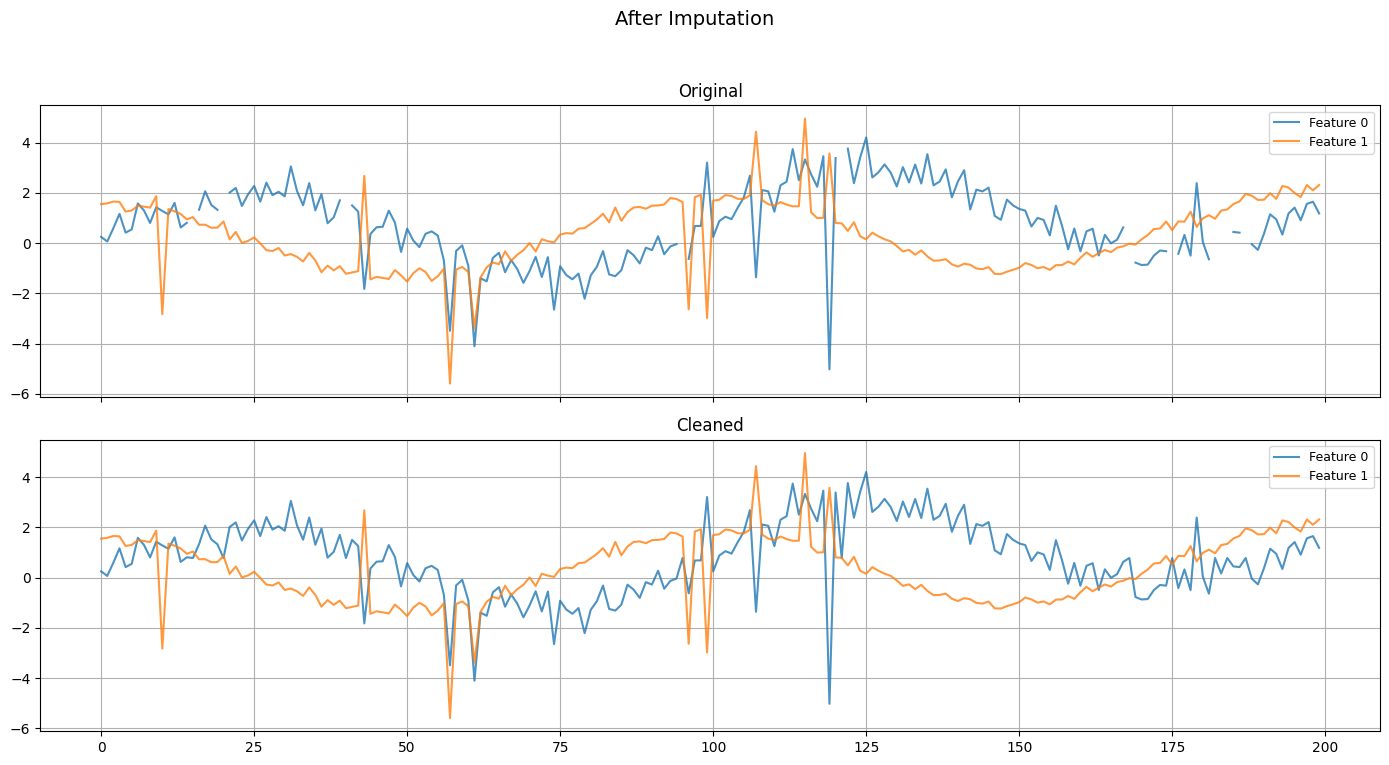

[Outlier Removal] Method: iqr, Threshold: 0.05
[Outlier Removal] Method: iqr, Threshold: 0.05


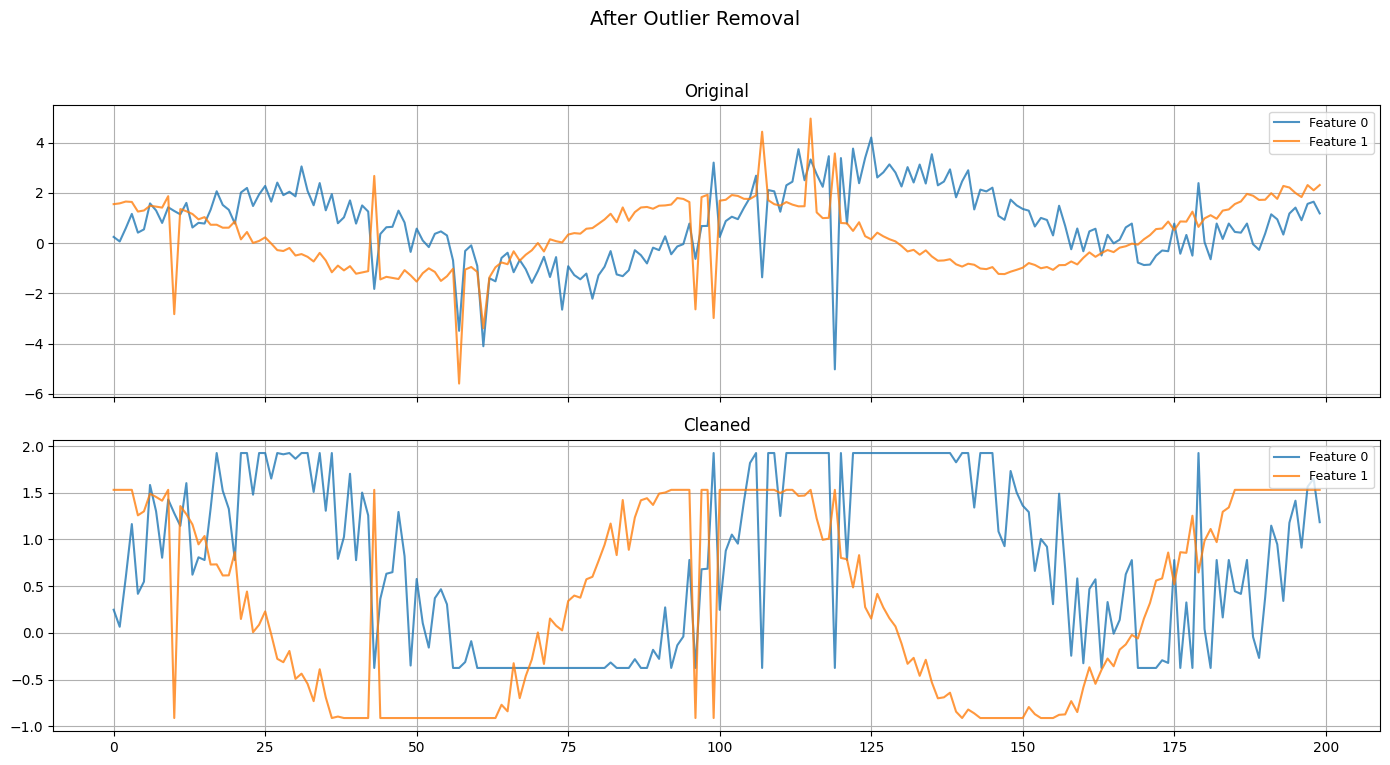

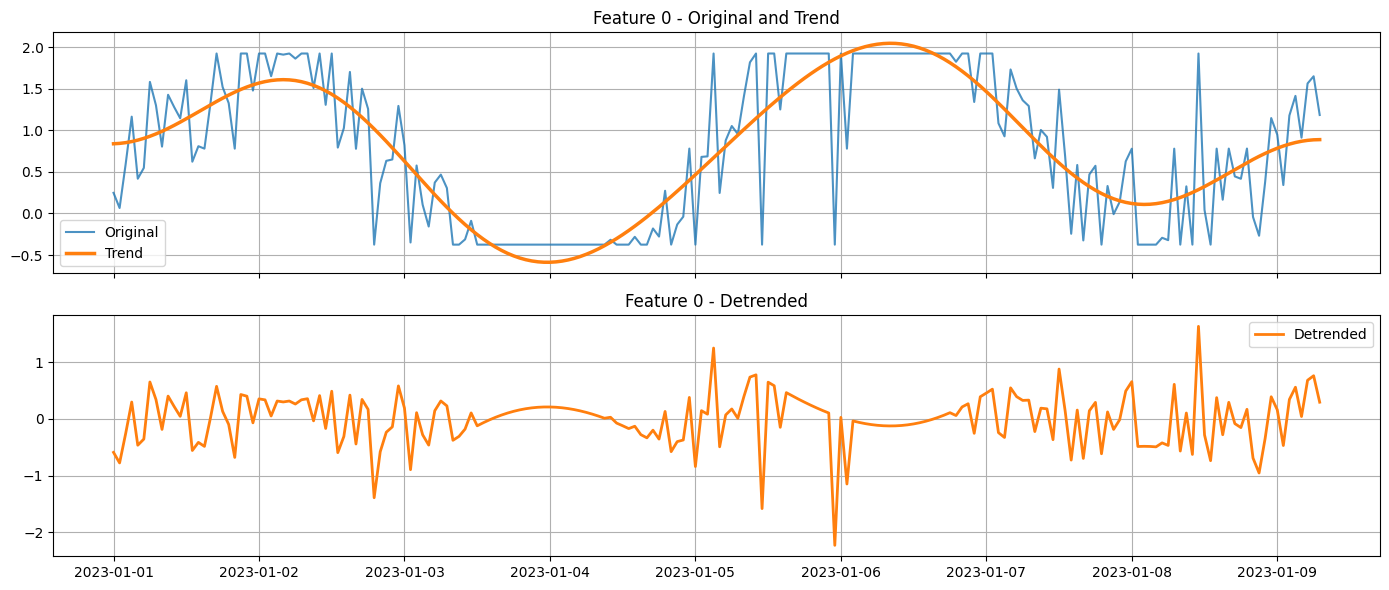

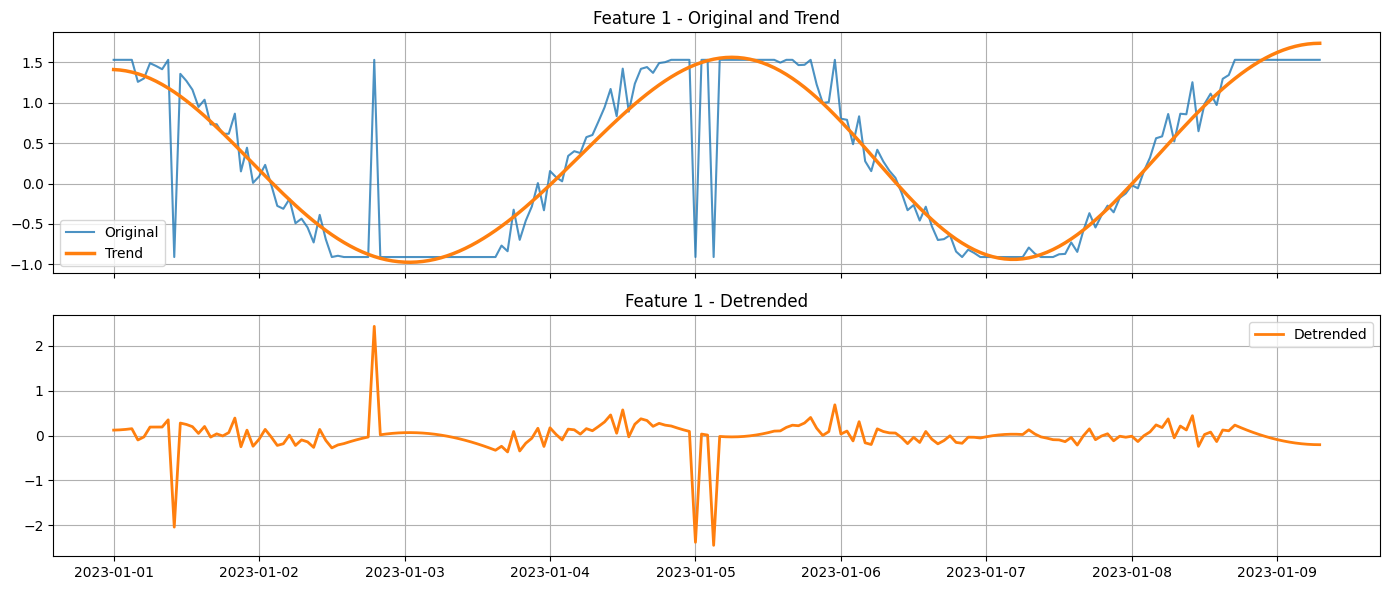

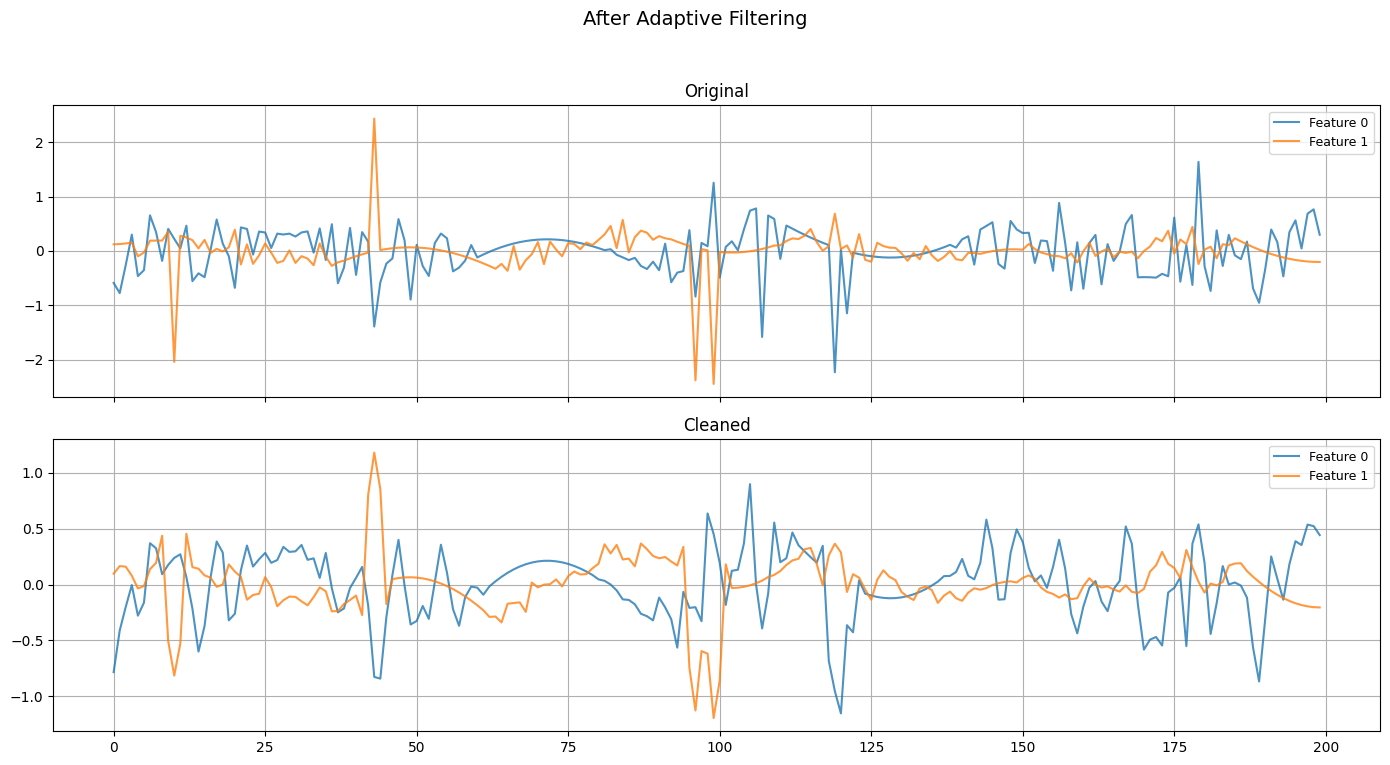

X shape: (165, 24, 6), y shape: (165, 12, 6)


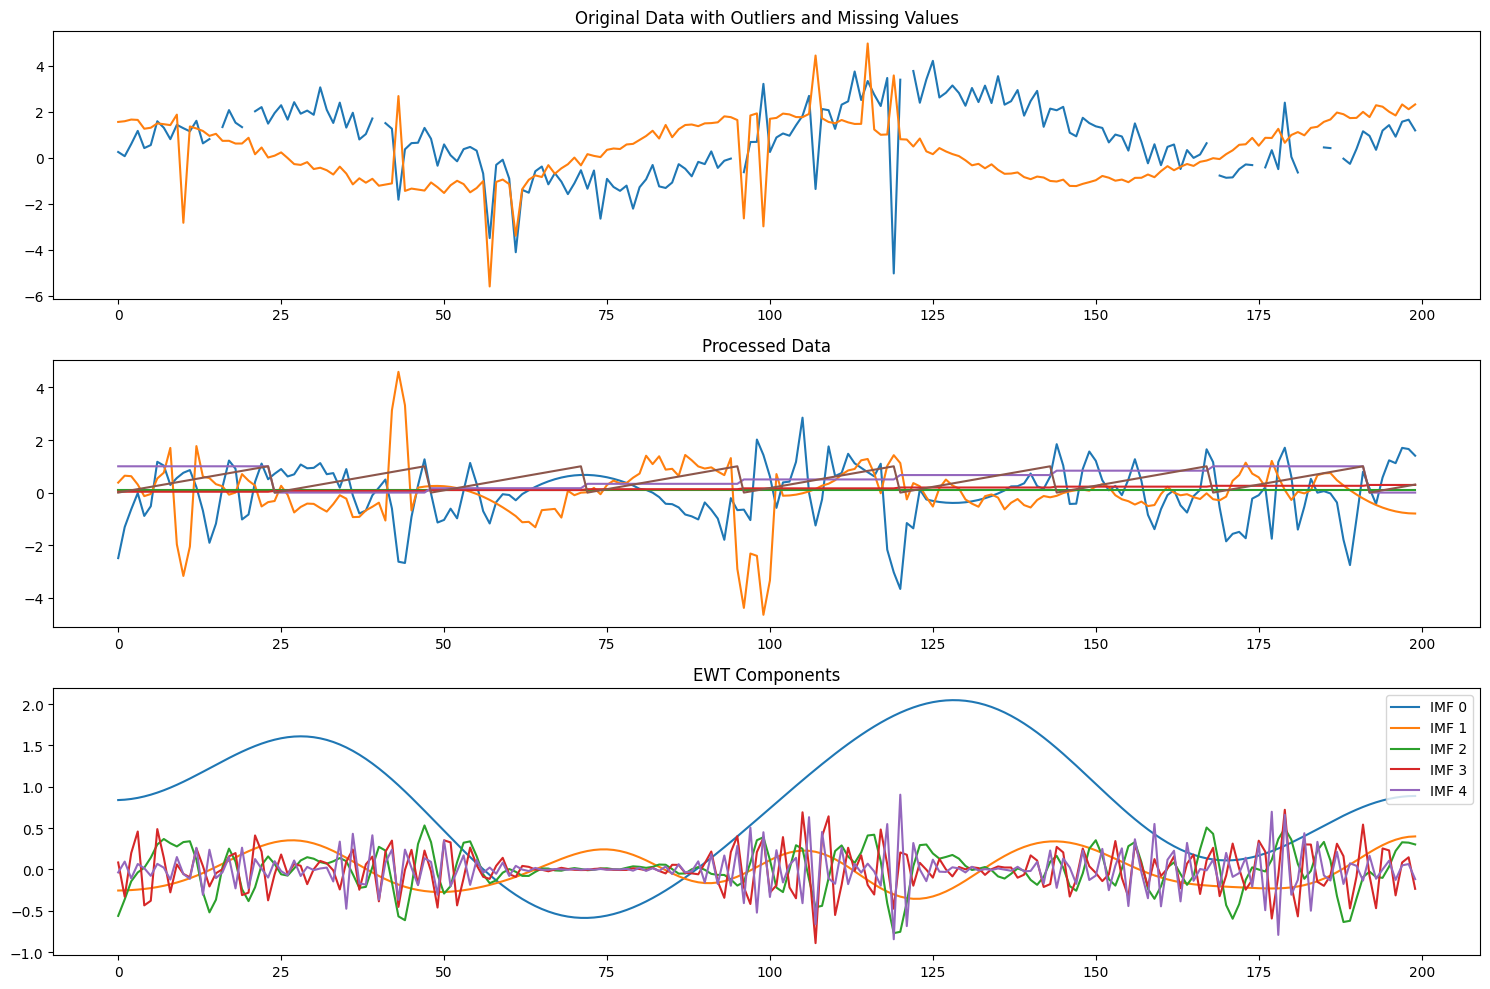

Input sequence shape: (165, 24, 6)
Target sequence shape: (165, 12, 6)


In [1]:
foreblocks = __import__('foreblocks')

import importlib
importlib.reload(foreblocks)
from foreblocks import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Generate synthetic time series data
np.random.seed(42)
n_samples = 200
timestamps = pd.date_range(start='2023-01-01', periods=n_samples, freq='H')

# Create a time series with trend, seasonality, and noise
t = np.linspace(0, 4*np.pi, n_samples)
trend = 0.1 * t
seasonality1 = 2 * np.sin(t)  # Daily pattern
seasonality2 = 1 * np.sin(t/24)  # Weekly pattern
noise = np.random.normal(0, 0.5, n_samples)

# Combine components
data = (trend + seasonality1 + seasonality2 + noise).reshape(-1, 1)

# Create a second feature (to demonstrate multivariate capabilities)
data2 = (0.5 * trend + 1.5 * np.cos(t) + 0.5 * np.random.normal(0, 0.3, n_samples)).reshape(-1, 1)
data = np.hstack([data, data2])  # Now we have shape [n_samples, 2]

# Add some outliers
outlier_indices = np.random.choice(n_samples, 10, replace=False)
data[outlier_indices] = data[outlier_indices] + 5 * np.random.randn(10, 2)

# Add some missing values (but not too many)
missing_indices = np.random.choice(n_samples, 10, replace=False)
data[missing_indices, 0] = np.nan  # Only make some values missing in first feature

# Create preprocessor with various techniques enabled
preprocessor = TimeSeriesPreprocessor(
    normalize=True,
    differencing=False,
    detrend=True,
    apply_ewt=True,
    window_size=24,
    horizon=12,
    remove_outliers=True,
    outlier_threshold=0.05,
    outlier_method="iqr",
    impute_method="iterative",
    ewt_bands=5,
    trend_imf_idx=0,
    log_transform=False,
    filter_window=5,
    filter_polyorder=2,
    apply_filter=True
)

# Fit and transform the data
X, y, processed_data = preprocessor.fit_transform(data, time_stamps=timestamps)

# Visualize the results
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.title('Original Data with Outliers and Missing Values')
plt.plot(data)

plt.subplot(3, 1, 2)
plt.title('Processed Data')
plt.plot(processed_data)

plt.subplot(3, 1, 3)
plt.title('EWT Components')
ewt_components = preprocessor.get_ewt_components()
if ewt_components:
    for i, imf in enumerate(ewt_components[0].T):
        plt.plot(imf, label=f'IMF {i}')
    plt.legend()

plt.tight_layout()
plt.show()

print(f"Input sequence shape: {X.shape}")
print(f"Target sequence shape: {y.shape}")

# TimeSeries

LSTMDecoder(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
)
Train loss: 0.6678
Train loss: 0.6632
Train loss: 0.6586
Train loss: 0.6541
Train loss: 0.6493
Train loss: 0.6445
Train loss: 0.6396
Train loss: 0.6344
Train loss: 0.6286
Train loss: 0.6227
Train loss: 0.6160
Train loss: 0.6088
Train loss: 0.6005
Train loss: 0.5911
Train loss: 0.5804
Train loss: 0.5679
Train loss: 0.5534
Train loss: 0.5374
Train loss: 0.5202
Train loss: 0.5054
Train loss: 0.4949
Train loss: 0.4930
Train loss: 0.5004
Train loss: 0.5047
Train loss: 0.5063
Train loss: 0.5020
Train loss: 0.4969
Train loss: 0.4907
Train loss: 0.4842
Train loss: 0.4825
Train loss: 0.4810
Train loss: 0.4789
Train loss: 0.4797
Train loss: 0.4741
Train loss: 0.4731
Train loss: 0.4758
Train loss: 0.4684
Train loss: 0.4613
Train loss: 0.4541
Train loss: 0.4468
Train loss: 0.4366
Train loss: 0.4225
Train loss: 0.4079
Train loss: 0.3933
Train loss: 0.3737
Train lo

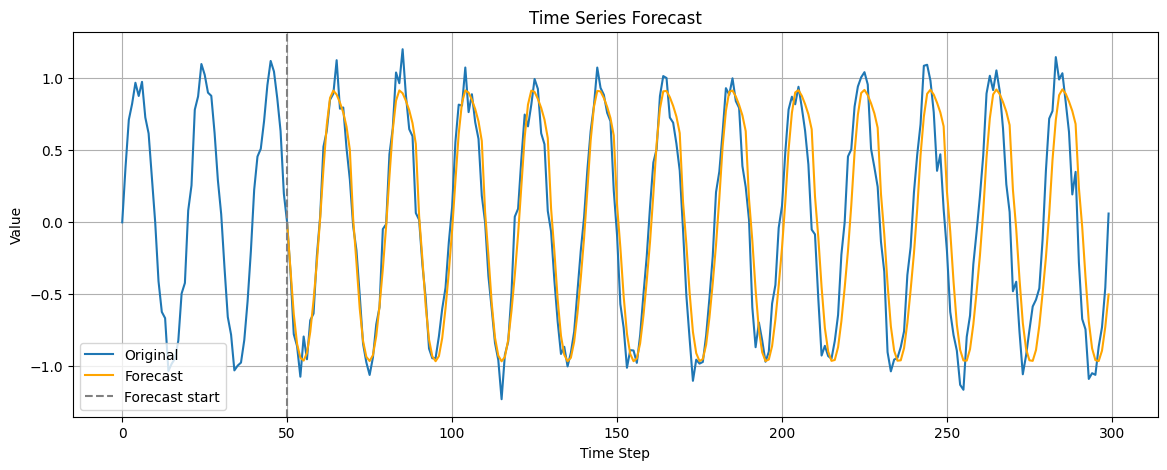

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

from foreblocks import ForecastingModel
from foreblocks import LSTMDecoder, LSTMEncoder

# Parameters
input_size = 1
hidden_size = 64
num_layers = 2
output_size = 1
target_len = 10
seq_len = 50
total_len = 300  # Total synthetic time series length

# 1. Create encoder and decoder
encoder = LSTMEncoder(input_size, hidden_size, num_layers)
decoder = LSTMDecoder(output_size, hidden_size, output_size, num_layers)

model = ForecastingModel(
    encoder=encoder,
    decoder=decoder,
    target_len=target_len,
    forecasting_strategy="seq2seq",
    teacher_forcing_ratio=0.5,
    output_size=output_size
)

# 2. Generate synthetic time series
time_series = np.sin(np.linspace(0, 30 * np.pi, total_len)) + 0.1 * np.random.randn(total_len)
time_series = torch.tensor(time_series, dtype=torch.float32).unsqueeze(-1)  # Shape: [T, 1]

# 3. Prepare sliding windows for training
def create_sliding_windows(series, input_len, output_len):
    X, Y = [], []
    for i in range(len(series) - input_len - output_len):
        X.append(series[i:i+input_len])
        Y.append(series[i+input_len:i+input_len+output_len])
    return torch.stack(X), torch.stack(Y)

X, Y = create_sliding_windows(time_series, seq_len, target_len)
train_size = int(0.8 * len(X))
X_train, Y_train = X[:train_size], Y[:train_size]

# 4. Train the model (1 epoch for demo)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
model.train()

for epoch in range(100):  # Increase for better training
    optimizer.zero_grad()
    output = model(X_train, Y_train)
    loss = criterion(output, Y_train)
    loss.backward()
    optimizer.step()
    print(f"Train loss: {loss.item():.4f}")

# 5. Forecast the full sequence autoregressively
model.eval()
input_seq = time_series[:seq_len].unsqueeze(0)  # [1, seq_len, 1]
forecast = []

with torch.no_grad():
    for _ in range((total_len - seq_len) // target_len):
        pred = model(input_seq, None)  # Teacher forcing off
        forecast.append(pred.squeeze(0))  # [target_len, 1]
        input_seq = torch.cat([input_seq[:, target_len:], pred], dim=1)

forecast = torch.cat(forecast, dim=0).squeeze().numpy()
ground_truth = time_series[seq_len:seq_len + len(forecast)].squeeze().numpy()

# 6. Plot results
plt.figure(figsize=(14, 5))
plt.plot(np.arange(len(time_series)), time_series.numpy(), label="Original")
plt.plot(np.arange(seq_len, seq_len + len(forecast)), forecast, label="Forecast", color="orange")
plt.axvline(x=seq_len, color="gray", linestyle="--", label="Forecast start")
plt.legend()
plt.title("Time Series Forecast")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.grid(True)
plt.show()
